In [ ]:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras import models
from keras import layers
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import json
from os import listdir
from os.path import isfile, join
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, MaxPooling1D, Embedding,LSTM,Dropout
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
from tensorflow.python.client import device_lib
import tensorflow as tf
import re

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/SD"

Sarcasm_Headlines_Dataset.json	Sarcasm_Headlines_Dataset_v2.json


In [ ]:
datadir="/content/gdrive/My Drive/SD/"

In [ ]:
data = pd.read_json('/content/gdrive/My Drive/SD/Sarcasm_Headlines_Dataset_v2.json', lines=True, orient='columns', encoding='utf-8')

In [ ]:
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [ ]:
data.describe()

,is_sarcastic
count,28619.000000
mean,0.476397
std,0.499451
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [ ]:
data.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


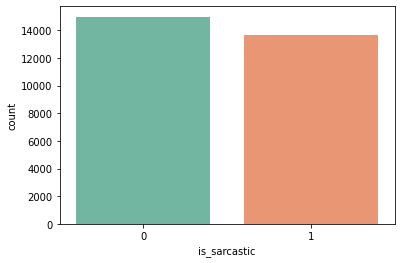

In [ ]:

ax = sns.countplot(data['is_sarcastic'],  palette="Set2")


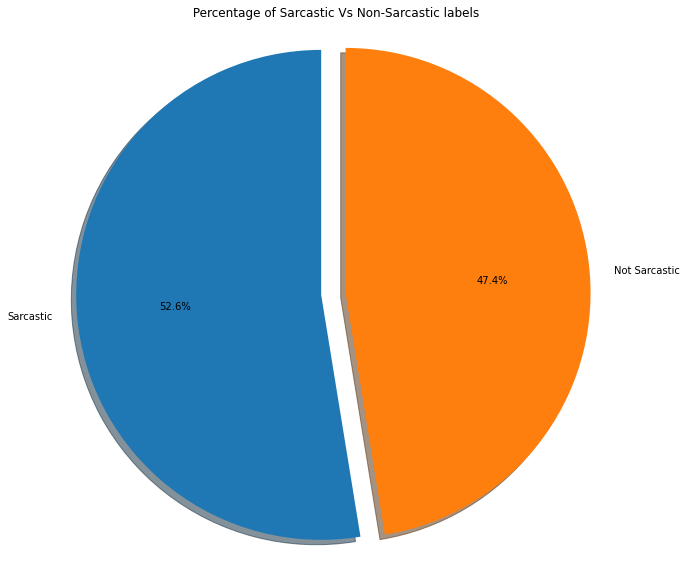

In [ ]:
labels = ['Sarcastic', 'Not Sarcastic']

z_percent = (data['is_sarcastic'].value_counts()[0]/ data['is_sarcastic'].value_counts().sum())*100
o_percent = (data['is_sarcastic'].value_counts()[1]/ data['is_sarcastic'].value_counts().sum())*100

sizes = [z_percent,o_percent]
explode = (0, 0.1)
plt.figure(figsize=(10,10))
plt.pie(sizes, labels=labels, explode = explode, 
        autopct='%1.1f%%', shadow=True, startangle= 90, pctdistance=0.6)
plt.axis('equal')
plt.title(" Percentage of Sarcastic Vs Non-Sarcastic labels")
plt.show()

In [ ]:
data['len'] = data['headline'].apply(lambda x: len(x.split(" ")))
data.head()

,is_sarcastic,headline,article_link,len
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,8
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,13
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,7
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,8
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,9


In [ ]:
data['len'].max()


151

In [ ]:
pd.options.display.max_colwidth = 300
data[data['len']==39]

,is_sarcastic,headline,article_link,len
24815,1,"elmore leonard, modern prose master, noted for his terse prose style and for writing about things perfectly and succinctly with a remarkable economy of words, unfortunately and sadly expired this gloomy tuesday at the age of 87 years old",https://www.theonion.com/elmore-leonard-modern-prose-master-noted-for-his-ters-1819575450,39


In [ ]:
data_length = data['len'].value_counts().reset_index()
data_length.rename(columns={'index': 'length_word', 'len':'frequency'}, inplace = True)
data_length.head()

,length_word,frequency
0,10,3636
1,9,3423
2,11,3395
3,8,2939
4,12,2843


Text(0.5, 1.0, ' Distribution of word length and its frequency')

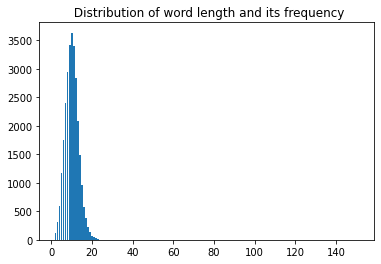

In [ ]:
import matplotlib.pyplot as plt
plt.bar(data_length['length_word'], data_length['frequency'])
plt.title(" Distribution of word length and its frequency")

Preprocessing

In [ ]:
data = data.drop(['article_link'], axis=1)
data.head()

,is_sarcastic,headline,len
0,1,thirtysomething scientists unveil doomsday clock of hair loss,8
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality",13
2,0,eat your veggies: 9 deliciously different recipes,7
3,1,inclement weather prevents liar from getting to work,8
4,1,mother comes pretty close to using word 'streaming' correctly,9


In [ ]:
def clean_data(x):
  return re.sub('[^A-Za-z ]+', '', x)


data['clean_hd'] = data["headline"].apply(clean_data)

In [ ]:
data.to_csv("/content/gdrive/My Drive/SD/clean.csv")

In [ ]:
data.head()


,is_sarcastic,headline,len,clean_hd
0,1,thirtysomething scientists unveil doomsday clock of hair loss,8,thirtysomething scientists unveil doomsday clock of hair loss
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality",13,dem rep totally nails why congress is falling short on gender racial equality
2,0,eat your veggies: 9 deliciously different recipes,7,eat your veggies deliciously different recipes
3,1,inclement weather prevents liar from getting to work,8,inclement weather prevents liar from getting to work
4,1,mother comes pretty close to using word 'streaming' correctly,9,mother comes pretty close to using word streaming correctly


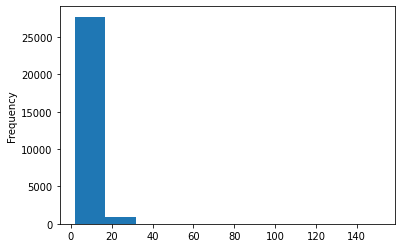

In [ ]:
data['len'].plot(kind='hist')
plt.show()

In [ ]:
# removing those headline whose length is greather than 15
print('shape before preprocessing ',data.shape)
data = data[data['len'] < 20]
print('shape after preprocessing ',data.shape)
data.head()

shape before preprocessing  (28619, 4)
shape after preprocessing  (28455, 4)


,is_sarcastic,headline,len,clean_hd
0,1,thirtysomething scientists unveil doomsday clock of hair loss,8,thirtysomething scientists unveil doomsday clock of hair loss
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality",13,dem rep totally nails why congress is falling short on gender racial equality
2,0,eat your veggies: 9 deliciously different recipes,7,eat your veggies deliciously different recipes
3,1,inclement weather prevents liar from getting to work,8,inclement weather prevents liar from getting to work
4,1,mother comes pretty close to using word 'streaming' correctly,9,mother comes pretty close to using word streaming correctly


In [ ]:
# Tokenization

In [ ]:
def tokenize_data(x):
  return x.split(" ")


In [ ]:
data["tokens"] = data["clean_hd"].apply(tokenize_data)
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,is_sarcastic,headline,len,clean_hd,tokens
0,1,thirtysomething scientists unveil doomsday clock of hair loss,8,thirtysomething scientists unveil doomsday clock of hair loss,"[thirtysomething, scientists, unveil, doomsday, clock, of, hair, loss]"
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality",13,dem rep totally nails why congress is falling short on gender racial equality,"[dem, rep, totally, nails, why, congress, is, falling, short, on, gender, racial, equality]"
2,0,eat your veggies: 9 deliciously different recipes,7,eat your veggies deliciously different recipes,"[eat, your, veggies, , deliciously, different, recipes]"
3,1,inclement weather prevents liar from getting to work,8,inclement weather prevents liar from getting to work,"[inclement, weather, prevents, liar, from, getting, to, work]"
4,1,mother comes pretty close to using word 'streaming' correctly,9,mother comes pretty close to using word streaming correctly,"[mother, comes, pretty, close, to, using, word, streaming, correctly]"


In [ ]:
#POS Tagging
def calc_pos(x):
  tokens = x.split(" ")
  try:
    tagged_sent = nltk.pos_tag(tokens)
  except:
    tagged_sent = ["Can not Pos"]
  
  return tagged_sent

In [ ]:
data_sar = data[data["is_sarcastic"] == 1]
data_non_sar = data[data["is_sarcastic"]==0]

In [ ]:
data_sar["pos"] = data_sar["clean_hd"].apply(calc_pos)
data_non_sar["pos"] = data_non_sar["clean_hd"].apply(calc_pos)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sarc_count ={}
non_sarc_count = {}
def pos_dict(x):
    try:
      pos_dict = dict(x)
    except:
      pos_dict = {}
    for k,v in pos_dict.items():
      if v in sarc_count:
        sarc_count[v]+=1
      else:
        sarc_count[v] = 1
    
    return pos_dict
   
def pos_dict_no_sarc(x):
    try:
      pos_dict = dict(x)
    except:
      pos_dict = {}
    for k,v in pos_dict.items():
      if v in non_sarc_count:
        non_sarc_count[v]+=1
      else:
        non_sarc_count[v] = 1
    
    return pos_dict
    
    
d1 = data_sar["pos"].apply(pos_dict)
d2 = data_non_sar["pos"].apply(pos_dict_no_sarc)

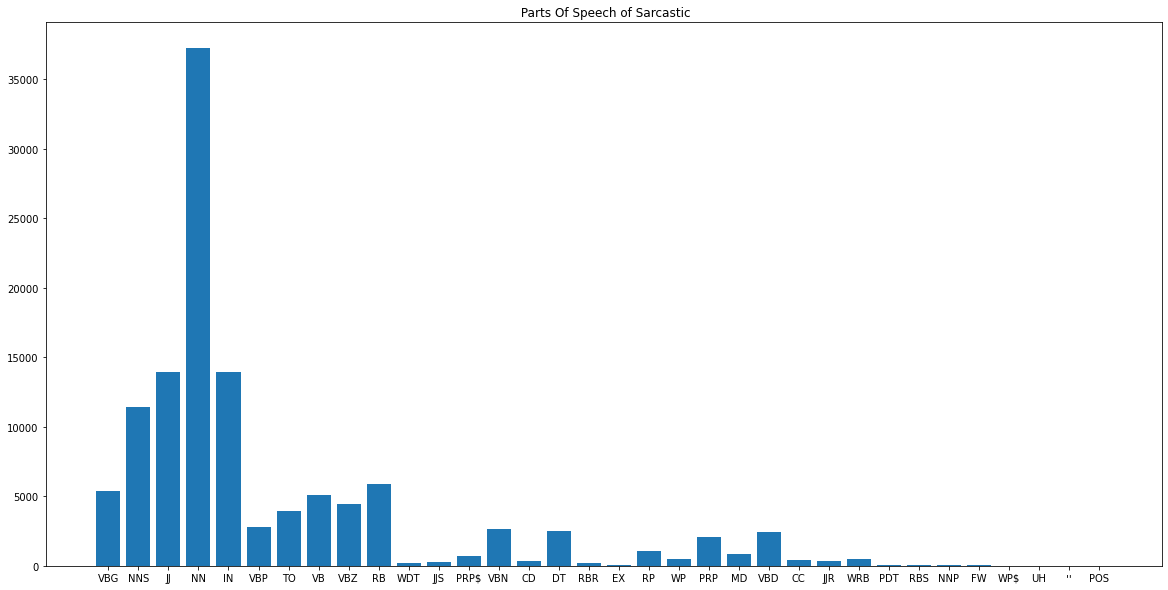

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))
plt.bar(range(len(sarc_count)), list(sarc_count.values()), align='center')
plt.xticks(range(len(sarc_count)), list(sarc_count.keys()))

# plt.bar(*zip(*sarc_count.items()), align = 'center')
plt.title(" Parts Of Speech  Sarcastic")
plt.show()

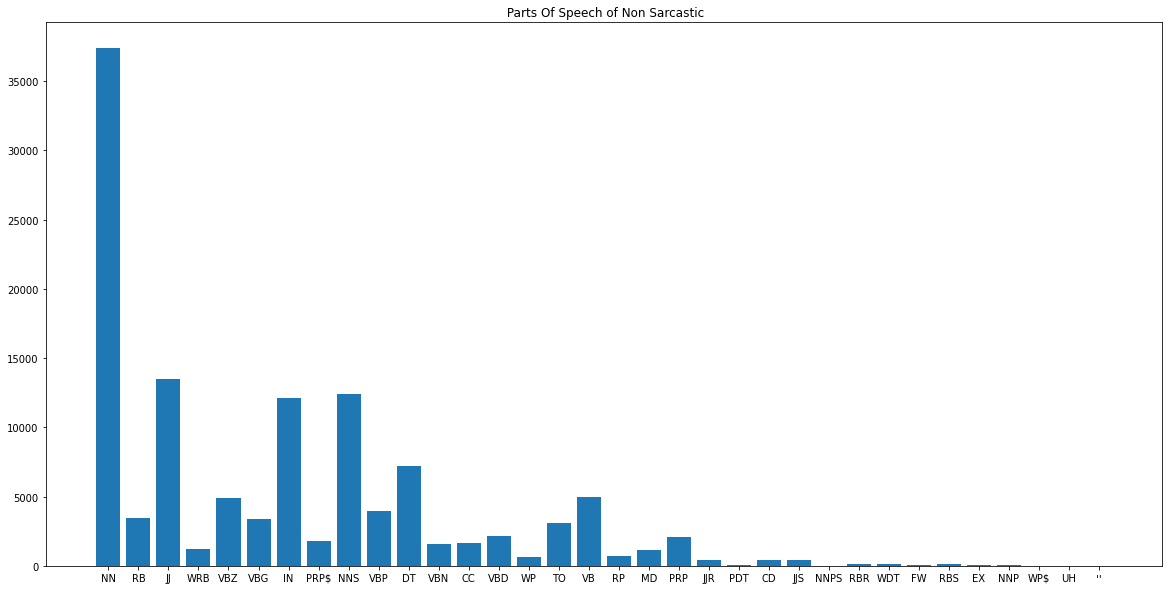

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.bar(*zip(*non_sarc_count.items()), align = 'center')
plt.title(" Parts Of Speech Non Sarcastic")
plt.show()

In [ ]:
# Lemmetization
lemm = WordNetLemmatizer()


def lemmat(x):
  try:
    x = x.split(" ")
    temp = []
    for i in x:
      temp.append(lemm.lemmatize(i))
    return temp
  except:
    return ["could not perform op"]

In [ ]:
data_sar["lemmatizer"] = data_sar["clean_hd"].apply(lemmat)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_sar.head()


,is_sarcastic,headline,len,clean_hd,tokens,pos,lemmatizer
0,1,thirtysomething scientists unveil doomsday clock of hair loss,8,thirtysomething scientists unveil doomsday clock of hair loss,"[thirtysomething, scientists, unveil, doomsday, clock, of, hair, loss]","[(thirtysomething, VBG), (scientists, NNS), (unveil, JJ), (doomsday, JJ), (clock, NN), (of, IN), (hair, NN), (loss, NN)]","[thirtysomething, scientist, unveil, doomsday, clock, of, hair, loss]"
3,1,inclement weather prevents liar from getting to work,8,inclement weather prevents liar from getting to work,"[inclement, weather, prevents, liar, from, getting, to, work]","[(inclement, NN), (weather, NN), (prevents, NNS), (liar, VBP), (from, IN), (getting, VBG), (to, TO), (work, VB)]","[inclement, weather, prevents, liar, from, getting, to, work]"
4,1,mother comes pretty close to using word 'streaming' correctly,9,mother comes pretty close to using word streaming correctly,"[mother, comes, pretty, close, to, using, word, streaming, correctly]","[(mother, NN), (comes, VBZ), (pretty, RB), (close, JJ), (to, TO), (using, VBG), (word, NN), (streaming, VBG), (correctly, RB)]","[mother, come, pretty, close, to, using, word, streaming, correctly]"
7,1,richard branson's global-warming donation nearly as much as cost of failed balloon trips,13,richard bransons globalwarming donation nearly as much as cost of failed balloon trips,"[richard, bransons, globalwarming, donation, nearly, as, much, as, cost, of, failed, balloon, trips]","[(richard, NN), (bransons, NNS), (globalwarming, VBG), (donation, NN), (nearly, RB), (as, RB), (much, JJ), (as, IN), (cost, NN), (of, IN), (failed, JJ), (balloon, NN), (trips, NNS)]","[richard, bransons, globalwarming, donation, nearly, a, much, a, cost, of, failed, balloon, trip]"
8,1,shadow government getting too large to meet in marriott conference room b,12,shadow government getting too large to meet in marriott conference room b,"[shadow, government, getting, too, large, to, meet, in, marriott, conference, room, b]","[(shadow, JJ), (government, NN), (getting, VBG), (too, RB), (large, JJ), (to, TO), (meet, VB), (in, IN), (marriott, NN), (conference, NN), (room, NN), (b, NN)]","[shadow, government, getting, too, large, to, meet, in, marriott, conference, room, b]"


In [ ]:
# stopword removal

data['headline_new'] = data['headline'].apply(lambda x: re.sub('[^a-zA-Z]','  ',x))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
noise_list = nltk.corpus.stopwords.words('english')


In [ ]:
data['headline_new'] = data['headline_new'].apply(lambda x: [i for i in x.split() if i not in noise_list])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()

In [ ]:
data['headline_new'] = data['headline_new'].apply(lambda x: [lem.lemmatize(i,'v') for i in x])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data['headline_new'] = data['headline_new'].apply(lambda x: [i.lower() for i in x])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
def join_lammatize(x):
  return " ".join(x)

data["lemmat"] = data["headline_new"].apply(join_lammatize)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
import nltk
from nltk.corpus import stopwords

stops = set(stopwords.words('english'))

#stopper lambda:

def stopper_lambda(x):
 
  words = x.split(" ")
  temp = []
  for word in words:
    if word not in stops:
      temp.append(word)
  return " ".join(temp)

In [ ]:
data["stopped"] = data["clean_hd"].apply(stopper_lambda)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data.head()


,is_sarcastic,headline,len,clean_hd,tokens,headline_new,lemmat,stopped
0,1,thirtysomething scientists unveil doomsday clock of hair loss,8,thirtysomething scientists unveil doomsday clock of hair loss,"[thirtysomething, scientists, unveil, doomsday, clock, of, hair, loss]","[thirtysomething, scientists, unveil, doomsday, clock, hair, loss]",thirtysomething scientists unveil doomsday clock hair loss,thirtysomething scientists unveil doomsday clock hair loss
1,0,"dem rep. totally nails why congress is falling short on gender, racial equality",13,dem rep totally nails why congress is falling short on gender racial equality,"[dem, rep, totally, nails, why, congress, is, falling, short, on, gender, racial, equality]","[dem, rep, totally, nail, congress, fall, short, gender, racial, equality]",dem rep totally nail congress fall short gender racial equality,dem rep totally nails congress falling short gender racial equality
2,0,eat your veggies: 9 deliciously different recipes,7,eat your veggies deliciously different recipes,"[eat, your, veggies, , deliciously, different, recipes]","[eat, veggies, deliciously, different, recipes]",eat veggies deliciously different recipes,eat veggies deliciously different recipes
3,1,inclement weather prevents liar from getting to work,8,inclement weather prevents liar from getting to work,"[inclement, weather, prevents, liar, from, getting, to, work]","[inclement, weather, prevent, liar, get, work]",inclement weather prevent liar get work,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'streaming' correctly,9,mother comes pretty close to using word streaming correctly,"[mother, comes, pretty, close, to, using, word, streaming, correctly]","[mother, come, pretty, close, use, word, stream, correctly]",mother come pretty close use word stream correctly,mother comes pretty close using word streaming correctly


In [ ]:
# embeddings using GloVE
MAX_SEQUENCE_LENGTH = 200
MAX_NUM_WORDS = 30000
EMBEDDING_DIM = 200 
VALIDATION_SPLIT = 0.2 
TEST_SPLIT = 0.2 
embeddings_index = {}
with open("/content/gdrive/My Drive/SD/glove.6B.200d.txt") as f:
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
print(" Found %s words of vectors" % len(embeddings_index))

 Found 400000 words of vectors


In [ ]:
Y = pd.get_dummies(data['is_sarcastic']).values
print(Y.shape)

X_train, Y_train, X_test, Y_test = train_test_split(data, Y, test_size = 0.2, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(28455, 2)
(22764, 8) (5691, 8)
(22764, 2) (5691, 2)


In [ ]:
corpus_selection = "headline"


In [ ]:


# texts = data["lemmat"]  # lemmatized data
texts = data[corpus_selection] #simple data
# texts = data["headline"] #with punctuation
#texts = data["stopped"] #without stop words

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 30723 unique tokens.


In [ ]:
seq


array([[    0,     0,     0, ...,     2,   652,  1095],
       [    0,     0,     0, ...,  1567,  2134,  1899],
       [    0,     0,     0, ..., 15885,   641,  1467],
       ...,
       [    0,     0,     0, ...,     6,   866,  1898],
       [    0,     0,     0, ...,  2328,   821,  6247],
       [    0,     0,     0, ...,     6,   255,   177]], dtype=int32)

In [ ]:
from sklearn.model_selection  import train_test_split
from keras.callbacks import LearningRateScheduler
from keras.layers import Input,Dense,Dropout,GlobalMaxPooling1D
import keras
from keras.models import Model

In [ ]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
        

print(embedding_matrix.shape)

(30000, 200)


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(seq, data["is_sarcastic"], test_size=0.20, random_state=42)


Naive Bayes


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [ ]:
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data[corpus_selection],data['is_sarcastic'],random_state=33)

#Train and evaluate the model
vect = CountVectorizer().fit(X_train)
#vectorize sentences
X_train_vectorized = vect.transform(X_train)

#create and fit a multinomial naive bayes
clfrNB = MultinomialNB(alpha = 0.5)


clfrNB.fit(X_train_vectorized, y_train)


preds = clfrNB.predict(vect.transform(X_test))

naive_score = clfrNB.score(vect.transform(X_test),y_test)

score = roc_auc_score(y_test, preds)
print(metrics.classification_report(y_test,preds))
print(score)

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      3746
           1       0.84      0.83      0.84      3368

    accuracy                           0.85      7114
   macro avg       0.85      0.85      0.85      7114
weighted avg       0.85      0.85      0.85      7114

0.8450519826056742


Random Forest Classifier

In [ ]:
rfc =  RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0)
rfc.fit(X_train_vectorized,y_train)
preds = rfc.predict(vect.transform(X_test))

In [ ]:
print(metrics.classification_report(y_test,preds))
random_fo_score = rfc.score(vect.transform(X_test),y_test)

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      3746
           1       0.99      0.09      0.16      3368

    accuracy                           0.57      7114
   macro avg       0.77      0.54      0.44      7114
weighted avg       0.76      0.57      0.45      7114



In [ ]:
random_fo_score

0.5681754287320776

SVC

In [ ]:
svc_l1 = LinearSVC(dual= False)
svc_l2 = LinearSVC(penalty="l1",dual=False)

In [ ]:
svc_l1.fit(X_train_vectorized,y_train)


LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
svc_l2.fit(X_train_vectorized,y_train)


LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l1', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
svc_l1_score = svc_l1.score(vect.transform(X_test),y_test)


In [ ]:
svc_l1_score

0.8190891200449817

In [ ]:
svc_l2_score = svc_l2.score(vect.transform(X_test),y_test)
svc_l2_score

0.8192296879392746

Logistic Regression


In [ ]:
lgr = LogisticRegression(random_state=0)


In [ ]:
lgr.fit(X_train_vectorized,y_train)
y_pred = lgr.predict(vect.transform(X_test))


logistic_score = lgr.score(vect.transform(X_test),y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      3746
           1       0.84      0.83      0.83      3368

    accuracy                           0.84      7114
   macro avg       0.84      0.84      0.84      7114
weighted avg       0.84      0.84      0.84      7114



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(seq, data["is_sarcastic"], test_size=0.20, random_state=42)


In [ ]:
from keras.callbacks import Callback

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.05
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return 0.0005**epoch

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


lr = LearningRateScheduler(step_decay, verbose=1)


embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

embedded_sequences = keras.layers.SpatialDropout1D(0.3)(embedded_sequences)
x = LSTM(200,return_sequences=False)(embedded_sequences)
x = Dense(512,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(256,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(128,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(32,activation="relu")(x)
x = Dropout(0.2)(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [ ]:
model.summary()


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 200)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               102912    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)              

Epoch 1/10
712/712 [==============================] - ETA: 0s - loss: 0.5649 - acc: 0.7074

<Figure size 432x288 with 0 Axes>

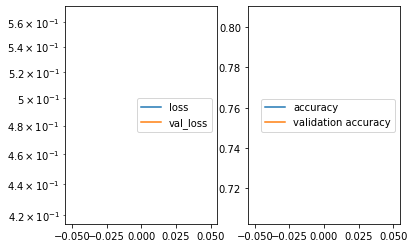

712/712 [==============================] - 380s 534ms/step - loss: 0.5649 - acc: 0.7074 - val_loss: 0.4208 - val_acc: 0.8053
Epoch 2/10
712/712 [==============================] - ETA: 0s - loss: 0.4060 - acc: 0.8205

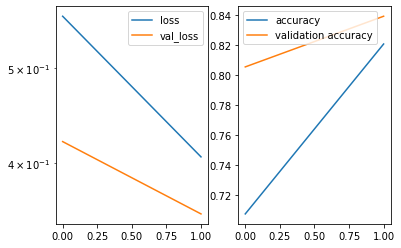

712/712 [==============================] - 407s 572ms/step - loss: 0.4060 - acc: 0.8205 - val_loss: 0.3551 - val_acc: 0.8390
Epoch 3/10
712/712 [==============================] - ETA: 0s - loss: 0.3435 - acc: 0.8546

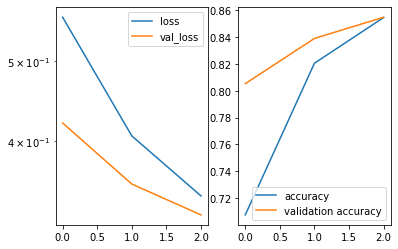

712/712 [==============================] - 388s 544ms/step - loss: 0.3435 - acc: 0.8546 - val_loss: 0.3259 - val_acc: 0.8549
Epoch 4/10
712/712 [==============================] - ETA: 0s - loss: 0.3121 - acc: 0.8683

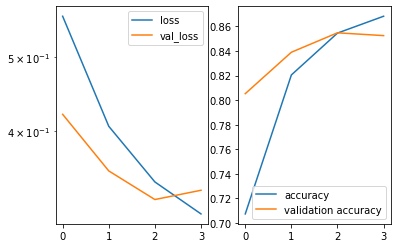

712/712 [==============================] - 379s 533ms/step - loss: 0.3121 - acc: 0.8683 - val_loss: 0.3351 - val_acc: 0.8526
Epoch 5/10
712/712 [==============================] - ETA: 0s - loss: 0.2742 - acc: 0.8866

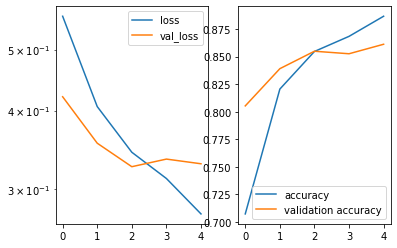

712/712 [==============================] - 402s 565ms/step - loss: 0.2742 - acc: 0.8866 - val_loss: 0.3294 - val_acc: 0.8612
Epoch 6/10
712/712 [==============================] - ETA: 0s - loss: 0.2415 - acc: 0.9020

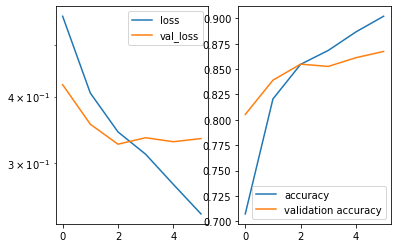

712/712 [==============================] - 405s 569ms/step - loss: 0.2415 - acc: 0.9020 - val_loss: 0.3338 - val_acc: 0.8673
Epoch 7/10
712/712 [==============================] - ETA: 0s - loss: 0.2113 - acc: 0.9136

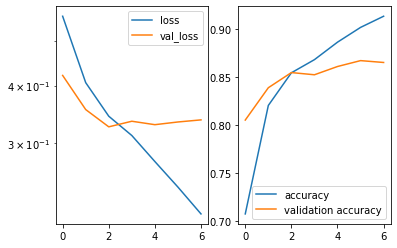

712/712 [==============================] - 404s 567ms/step - loss: 0.2113 - acc: 0.9136 - val_loss: 0.3373 - val_acc: 0.8654
Epoch 8/10
712/712 [==============================] - ETA: 0s - loss: 0.1900 - acc: 0.9233

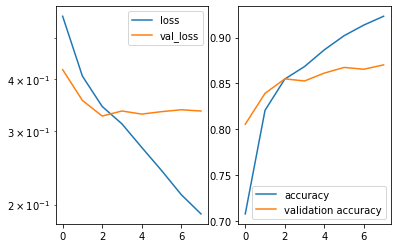

712/712 [==============================] - 388s 545ms/step - loss: 0.1900 - acc: 0.9233 - val_loss: 0.3350 - val_acc: 0.8701
Epoch 9/10
712/712 [==============================] - ETA: 0s - loss: 0.1614 - acc: 0.9368

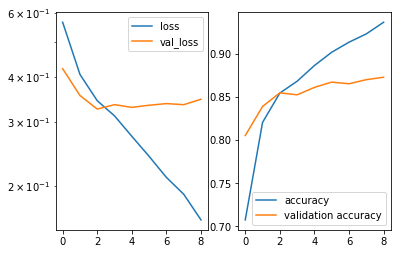

712/712 [==============================] - 380s 533ms/step - loss: 0.1614 - acc: 0.9368 - val_loss: 0.3468 - val_acc: 0.8730
Epoch 10/10
712/712 [==============================] - ETA: 0s - loss: 0.1549 - acc: 0.9375

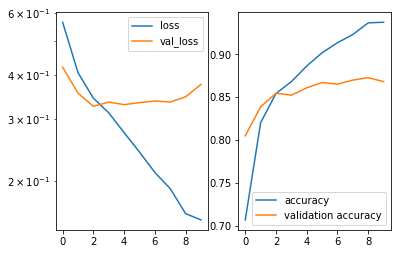

712/712 [==============================] - 379s 532ms/step - loss: 0.1549 - acc: 0.9375 - val_loss: 0.3762 - val_acc: 0.8684


In [ ]:
history=model.fit(X_train, y_train,
          batch_size=32,
          epochs=10,
            validation_data=(X_test, y_test),callbacks=[PlotLearning()])

In [ ]:
rnn_score = model.evaluate(X_test,y_test)


178/178 [==============================] - 30s 170ms/step - loss: 0.3762 - acc: 0.8684


In [ ]:
rnn_score

[0.37615230679512024, 0.8683887124061584]

In [ ]:
result_dict = {"Logistic Regression":logistic_score *100,"SVC with L1":svc_l1_score*100,"SVC with L2":svc_l2_score *100,"Multinomial NB":naive_score*100,
                  "Random Forest":(random_fo_score) *100, "RNN":rnn_score[1] *100 }

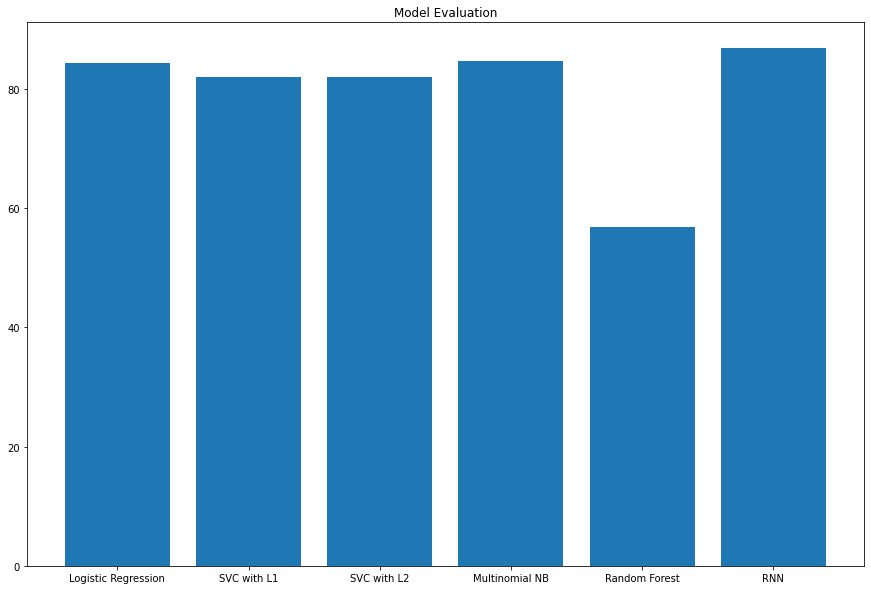

In [ ]:
fig = plt.figure(figsize=(15,10))

plt.bar(range(len(result_dict)), list(result_dict.values()), align='center')
plt.xticks(range(len(result_dict)), list(result_dict.keys()))
plt.title("Model Evaluation")
plt.show()